In [1]:
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, BitsAndBytesConfig,AutoModelForCausalLM
from datasets import load_dataset
import torch.nn.utils.prune as prune
import torch
import platform
import time
import numpy as np
from tqdm import tqdm
import logging
import json, pprint
from peft import LoraConfig, get_peft_model
from peft.tuners.lora import LoraLayer
import copy, numpy as np, warnings
import math
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No Cuda!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Python version: 3.9.9
PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU model: Tesla T4
Number of GPUs: 1
Available GPU memory: 15.64 GB
Using device: cuda


In [3]:
def compute_perplexity(model, tokenizer, texts, device, batch_size=8, max_length=128):
    model.eval()
    losses = []
    total_evaluated = 0
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        if not batch: continue
        total_evaluated += len(batch)
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        outputs = model(**inputs, labels=inputs.input_ids)
        if hasattr(outputs, 'loss') and outputs.loss is not None:
            losses.append(outputs.loss.item() * len(batch))
    if not losses or total_evaluated == 0: return float('inf')
    avg_loss = sum(losses) / total_evaluated
    if avg_loss <= 0: return float('inf')
    return math.exp(avg_loss)
    
def apply_pruning(model_to_prune, amount):
    parameters_to_prune = []
    target_modules = set()
    print("Starting parameter search for pruning...")
    for name, module in model_to_prune.named_modules():
         if isinstance(module, LoraLayer):
             print(f"Found LoraLayer: {name}")
             for key in ['lora_A', 'lora_B']:
                if hasattr(module, key):
                    sub_module_dict = getattr(module, key)
                    if isinstance(sub_module_dict, torch.nn.ModuleDict):
                         for adapter_name, sub_module in sub_module_dict.items():
                             if hasattr(sub_module, 'weight'):
                                print(f"   Found weight in {key}.{adapter_name}. Adding.")
                                parameters_to_prune.append((sub_module, 'weight'))
                                target_modules.add(sub_module)
                    elif isinstance(sub_module_dict, torch.nn.Module):
                        if hasattr(sub_module_dict, 'weight'):
                            print(f"   Found weight directly in {key}. Adding.")
                            parameters_to_prune.append((sub_module_dict, 'weight'))
                            target_modules.add(sub_module_dict)

    if not parameters_to_prune:
        print("Could not find any LoRA parameters to prune!")
        return 0.0
    else:
        print(f"Identified {len(parameters_to_prune)} parameter tensors for pruning.")
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
        print("Pruning mask applied. Making pruning permanent...")
        final_total_params = 0; final_zero_params = 0; pruned_module_count = 0
        for module in target_modules:
            is_currently_pruned = prune.is_pruned(module)
            if is_currently_pruned:
                 try:
                     mask = getattr(module, 'weight_mask', None); orig_param = getattr(module, 'weight_orig', None)
                     if mask is not None and orig_param is not None:
                          param_element_count = orig_param.nelement(); param_zero_count = torch.sum(mask == 0).item()
                          final_total_params += param_element_count; final_zero_params += param_zero_count
                     elif hasattr(module, 'weight'):
                          param = getattr(module, 'weight'); final_total_params += param.nelement(); final_zero_params += torch.sum(param == 0).item()
                 except AttributeError:
                       if hasattr(module, 'weight'):
                           param = getattr(module, 'weight'); final_total_params += param.nelement(); final_zero_params += torch.sum(param == 0).item()
                 prune.remove(module, 'weight'); pruned_module_count += 1
            elif hasattr(module, 'weight'):
                 param = getattr(module, 'weight'); final_total_params += param.nelement()
        print(f"Removed pruning buffer from {pruned_module_count} modules.")
        if final_total_params > 0:
            final_sparsity = 100. * float(final_zero_params) / float(final_total_params)
            print(f"Pruning made permanent. Calculated sparsity: {final_sparsity:.2f}%")
            return final_sparsity
        else:
            print("Pruning made permanent (no parameters found or counted)."); return 0.0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
train_texts_full = [t for t in dataset["train"]["text"] if t.strip()]
val_texts_full = [t for t in dataset["validation"]["text"] if t.strip()]
model_distilled_base = AutoModelForCausalLM.from_pretrained("./distilled_model").to(device)
for param in model_distilled_base.parameters(): param.requires_grad = False
lora_r = 8
lora_alpha = 32
lora_target_modules = ["c_attn"]
baseline_lr = 5e-5
lora_lr = 1e-4

lora_cfg = LoraConfig(
r=lora_r, lora_alpha=lora_alpha, target_modules=lora_target_modules,
lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)

lora_model_distilled = get_peft_model(model_distilled_base, lora_cfg)
lora_model_distilled.print_trainable_parameters()
lora_model_distilled.train()
optim = torch.optim.AdamW(lora_model_distilled.parameters(), lr=1e-3)

tmp_inputs = tokenizer(
    ["Just a short dummy batch."], return_tensors="pt"
).to(device)
loss = lora_model_distilled(**tmp_inputs,
                            labels=tmp_inputs.input_ids).loss
loss.backward(); optim.step(); optim.zero_grad()
lora_model_distilled.eval()

/home/tgs2126/py39_env/lib/python3.9/site-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
          

In [5]:
def pick_pruning_ratio(
    base_model,
    tokenizer,
    val_texts,
    device,
    candidate_amounts = np.arange(0.0, 1.0, 0.1),   
    quality_budget = 1.0,                            
    quick_tokens   = 1000,                          
    batch_size     = 16,
    max_length     = 128
):
    """Return pruning ratio that gives best memory win while staying within
       `quality_budget` PPL increase wrt the un-pruned baseline.
    """
    # 1) compute baseline PPL once
    baseline_ppl = compute_perplexity(
        base_model, tokenizer,
        val_texts[:quick_tokens], device,
        batch_size=batch_size, max_length=max_length
    )
    print(f"[Sweep] Baseline (0 %): PPL={baseline_ppl:.2f}")

    scores = OrderedDict()
    for amt in candidate_amounts[1:]:     
        model_copy = copy.deepcopy(base_model).to(device)
        apply_pruning(model_copy, amt)

        ppl = compute_perplexity(
            model_copy, tokenizer,
            val_texts[:quick_tokens], device,
            batch_size=batch_size, max_length=max_length
        )
        delta = ppl - baseline_ppl
        scores[amt] = (ppl, delta)

        print(f"[Sweep] {int(amt*100):>2}% sparsity → "
                    f"PPL={ppl:.2f} (Δ {delta:+.2f})")

        del model_copy
        torch.cuda.empty_cache()

    # 2) choose the highest sparsity that meets quality budget
    feasible = [a for a,(ppl,delta) in scores.items() if delta <= quality_budget]
    if not feasible:
        warnings.warn("No candidate met the quality budget; falling back to 0.0")
        return 0.0

    best_amount = max(feasible)
    print(f"[Sweep] Selected pruning ratio = {best_amount:.2f} "
                f"({int(best_amount*100)} %)")
    return best_amount


[Sweep] Baseline ( 0 %) PPL = 1114.25
Starting parameter search for pruning...
Found LoraLayer: base_model.model.transformer.h.0.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model.transformer.h.1.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model.transformer.h.2.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model.transformer.h.3.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model.transformer.h.4.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model.transformer.h.5.attn.c_attn
   Found weight in lora_A.default. Adding.
   Found weight in lora_B.default. Adding.
Found LoraLayer: base_model.model

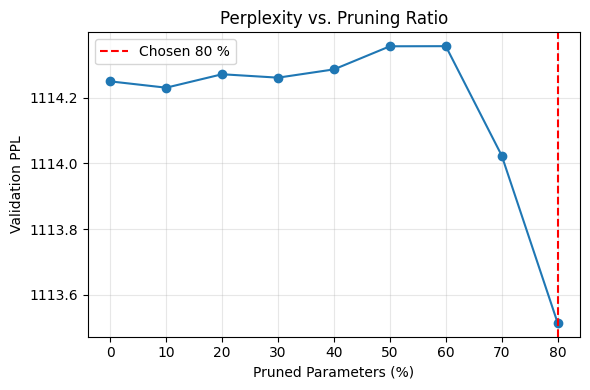


Using pruning_amount = 0.80


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import warnings, math, copy, torch

def pick_pruning_ratio(
    base_model,
    tokenizer,
    val_texts,
    device,
    candidate_amounts=np.arange(0.0, 0.9, 0.1),  
    quality_budget=1.0,                           # tolerate +1 PPL
    quick_tokens=1000,
    batch_size=16,
    max_length=128,
    plot=True                                    
):
    """
    Sweep over pruning ratios and pick the highest sparsity whose
    ∆PPL ≤ `quality_budget`.  If `plot` is True, draw a PPL-vs-sparsity
    chart and mark the selected elbow point.
    
    Returns
    -------
    best_amount : float
        The selected pruning ratio (e.g. 0.8 for 80 %).
    sweep_data  : OrderedDict[float, float]
        Mapping sparsity → PPL for every candidate tested.
    """

    #  baseline 
    baseline_ppl = compute_perplexity(
        base_model, tokenizer,
        val_texts[:quick_tokens], device,
        batch_size=batch_size, max_length=max_length
    )
    print(f"[Sweep] Baseline ( 0 %) PPL = {baseline_ppl:.2f}")

    sweep_data = OrderedDict({0.0: baseline_ppl})
    for amt in candidate_amounts[1:]:
        model_copy = copy.deepcopy(base_model).to(device)
        apply_pruning(model_copy, amt)

        ppl = compute_perplexity(
            model_copy, tokenizer,
            val_texts[:quick_tokens], device,
            batch_size=batch_size, max_length=max_length
        )
        sweep_data[amt] = ppl
        print(f"[Sweep] {int(amt*100):2d} % sparsity → PPL={ppl:.2f} "
              f"(∆ {ppl-baseline_ppl:+.2f})")

        del model_copy
        torch.cuda.empty_cache()

    #  choose ratio 
    feasible = [a for a,ppl in sweep_data.items() if ppl-baseline_ppl <= quality_budget]
    if not feasible:
        warnings.warn("No candidate met the quality budget; falling back to 0 %.")
        best_amount = 0.0
    else:
        best_amount = max(feasible)

    print(f"[Sweep] Selected pruning ratio = {int(best_amount*100)} %")

    #  optional plot 
    if plot:
        sparsities = 100*np.array(list(sweep_data.keys()))
        ppls       = np.array(list(sweep_data.values()))

        plt.figure(figsize=(6,4))
        plt.plot(sparsities, ppls, marker='o')
        plt.axvline(100*best_amount, color='r', linestyle='--', label=f"Chosen {int(best_amount*100)} %")
        plt.title("Perplexity vs. Pruning Ratio")
        plt.xlabel("Pruned Parameters (%)")
        plt.ylabel("Validation PPL")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return best_amount, sweep_data


#  usage 
pruning_amount, sweep = pick_pruning_ratio(
    lora_model_distilled,
    tokenizer,
    val_texts_full,
    device=device,
    candidate_amounts=np.arange(0.0, 0.81, 0.1),
    quality_budget=1.0,
    quick_tokens=1000,
    plot=True          
)

print(f"\nUsing pruning_amount = {pruning_amount:.2f}")
